# Spatial and Temporal Subsetting of Gridded MEaSURES SIF Data

This tutorial demonstrates two simple scenarios of subsetting the gridded MEaSURES SIF data from the ORNL DAAC's Thematic Real-time Environmental Distributed Data Services (THREDDS) Data Server (TDS) using Python. 
- Scenario 1: Spatial subsetting within a region at certain time points
- Scenario 2: Time series subsetting at a specific point location

The science driver for these two scenarios is to investigate how SIF measurements in the Great Smoky Mountains National Park were affected by the [2016 Great Smoky Mountains wildfires](https://en.wikipedia.org/wiki/2016_Great_Smoky_Mountains_wildfires).

**Datasets used in this tutorial:**
- [High Resolution Global Contiguous SIF Estimates from OCO-2 SIF and MODIS, Version 2](https://doi.org/10.3334/ORNLDAAC/1863) (a.k.a., dataset 1863)
- [Global High-Resolution Estimates of SIF from Fused SCIAMACHY and GOME-2, 2002-2018](https://doi.org/10.3334/ORNLDAAC/1864) (a.k.a., dataset 1864)

### 1. Import python modules

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap  
from siphon import catalog, ncss
import datetime
import pandas as pd
import geopandas as gpd
import contextily as ctx
import folium
from cftime import num2pydate
from shapely.geometry import Point
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature


%matplotlib inline

## This tutorial uses one of the two MEaSURES SIF datasets (see above). 
## To switch from one dataset to the other, simply switch the parameters below

# URL of the SIF dataset in the ORNL DAAC THREDDS Data Server
tds_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1863-agg/catalog.xml'  # for dataset 1863
#tds_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1864-agg/catalog.xml' # for dataset 1864

# name of the data variable containing SIF measurements
vname = 'sif_ann'                 # for dataset 1863
#vname = 'SIF_740_daily_corr'     # for dataset 1864

# adjust SIF levels (for visualization purpose) to match SIF data values from different datasets
# (min_SIF_value, max_SIF_value, number_of_levels)
sif_levels = np.linspace(0.0, 0.7, 151)   # for dataset 1863
#sif_levels = np.linspace(0.6, 1.5, 181)   # for dataset 1864

### 2. Take a quick look at our study area and event

The Great Smoky Mountains National Park (GSMNP) is an American national park in the southeastern United States, with parts in Tennessee and North Carolina.

The 2016 Great Smoky Mountains wildfires, also known as the Gatlinburg wildfires, were a complex of wildfires which began in late November 2016. Some of the towns most impacted were Pigeon Forge and Gatlinburg, both near GSMNP. The fires claimed at least 14 lives, injured 190, and is one of the largest natural disasters in the history of Tennessee.

The map below shows the boundary of the boundary of the GSMNP and the center point of the wildfire event (denoted by the red dot on the map).

In this tutorial, we will investigate the SIF map in the area of GSMNP in the summer following the wildfires event and also see how SIF measurements at the wildfires center point change before and after the wildfires event.

Codes below load and display a shapefile representing the boundary of GSMNP, extract the bounding box (bbox) of the shapefile, and also define the latitude/longitude coordinates of the wildfires center point (the red dot).

        minx       miny       maxx       maxy
0 -84.000407  35.428963 -82.998041  35.839112


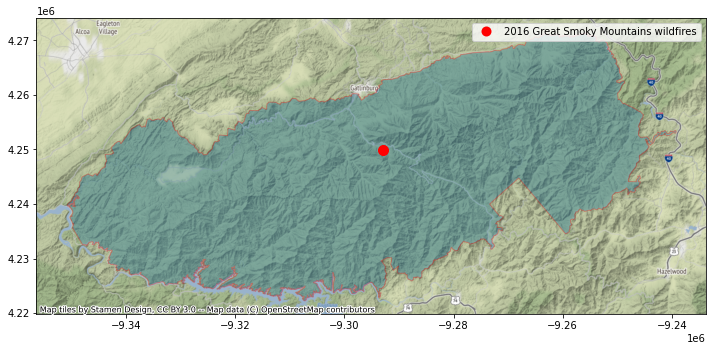

In [2]:
# latitude/longitude coordinates of the wildfires center point
fire_center_lat = 35.63
fire_center_lon = -83.48

# load the shapefile
gsmnp_bnd_4326 = gpd.read_file('bnds/GRSM_BOUNDARY_POLYGON_4326.shp')

# extract bbox of the shapefile
gsmnp_bbox = gsmnp_bnd_4326.bounds
gsmnp_bbox.maxy = gsmnp_bbox.maxy + 0.05 # increase the north bound by about 5km
print(gsmnp_bbox)

# display the shapefile and the center point dot
gsmnp_bnd_3857 = gsmnp_bnd_4326.to_crs(epsg=3857)
ax=gsmnp_bnd_3857.plot(figsize=(12, 6), alpha=0.3, edgecolor='red')

gsmnp_bnd_df = pd.DataFrame({'longitude': [fire_center_lon], 'latitude': [fire_center_lat], 'place_name': ['2016 Great Smoky Mountains wildfires']})
fire_place_4326 = gpd.points_from_xy(gsmnp_bnd_df.longitude, gsmnp_bnd_df.latitude, crs="EPSG:4326")
fire_place_3857 = fire_place_4326.to_crs(epsg=3857)
gsmnp_bnd_geo_df_4326 = gpd.GeoDataFrame(gsmnp_bnd_df[['latitude', 'longitude', 'place_name']], geometry=fire_place_4326)
gsmnp_bnd_geo_df_3857 = gpd.GeoDataFrame(gsmnp_bnd_df[['latitude', 'longitude', 'place_name']], geometry=fire_place_3857)
gsmnp_bnd_geo_df_3857.plot(column='place_name', ax=ax, cmap=ListedColormap('red'), markersize=100, legend=True)

ctx.add_basemap(ax)

### 3. Open the remote SIF dataset from the ORNL DAAC THREDDS Data Server

In [3]:
# open the catalog and identify the dataset
tds = catalog.TDSCatalog(tds_url)
datasets = list(tds.datasets)
print(datasets)

['Global_SIF_OCO2_MODIS.ncml']


#### 3.1. List different types of service APIs that we can use to access this dataset from the THREDDS Data Server

The ORNL DAAC THREDDS Data Server supports data access using different service APIs, like OPeNDAP, NetCDF Subset Service, and OGC Web Coverage Service. But we will use the NetCDF Subset Service API in this tutorial.

In [4]:
# List types of service APIs
endpts = list(tds.datasets.values())
for key, value in endpts[0].access_urls.items():
    print(key, value)

OPENDAP https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1863-agg/Global_SIF_OCO2_MODIS.ncml
HTTPServer https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/1863-agg/Global_SIF_OCO2_MODIS.ncml
WCS https://thredds.daac.ornl.gov/thredds/wcs/ornldaac/1863-agg/Global_SIF_OCO2_MODIS.ncml
WMS https://thredds.daac.ornl.gov/thredds/wms/ornldaac/1863-agg/Global_SIF_OCO2_MODIS.ncml
NetcdfSubset https://thredds.daac.ornl.gov/thredds/ncss/grid/ornldaac/1863-agg/Global_SIF_OCO2_MODIS.ncml
ISO https://thredds.daac.ornl.gov/thredds/iso/ornldaac/1863-agg/Global_SIF_OCO2_MODIS.ncml


#### 3.2. Choose the NetCDF Subset Service (NCSS) API 

In [5]:
# choose the NetCDF Subset Service (NCSS) API 
ncss = endpts[0].subset()
# print out the data variables in this dataset
print("Variables: " + str(ncss.metadata.variables))
# print out the full temporal range of this dataset
print("Temporal Extent: " + str(ncss.metadata.time_span))
# print out the full spatial extent (or bbox) of this dataset
print("Spatial Extent: " + str(ncss.metadata.lat_lon_box))

Variables: {'sif_ann': {'desc': 'mean solar-induced chlorophyll fluorescence modeled by an artificial neural network', 'shape': 'time lat lon', 'type': 'double', 'attributes': {'_FillValue': [-999.0], 'units': 'mW m-2 nm-1 sr-1', 'long_name': 'mean solar-induced chlorophyll fluorescence modeled by an artificial neural network', 'grid_mapping': 'crs', '_ChunkSizes': [3600, 7200]}}}
Temporal Extent: {'begin': '2014-09-08T12:00:00Z', 'end': '2020-07-24T06:00:00Z'}
Spatial Extent: {'west': -179.975, 'east': 179.975, 'south': -89.975, 'north': 89.9749}


### 4. Spatially subset the SIF data at the GSMNP area in summer 2016 and 2017

#### 4.1. Build a NCSS spatial subset request to retrieve data in summer 2016

In [6]:
# create an empty NCSS query object
spatial_query = ncss.query()
# tell the query to subset the sif data variable in netCDF v4 format
spatial_query.variables(vname).accept('netcdf4')
# tell the query to subset within the bbox of GSMNP
spatial_query.lonlat_box(north=gsmnp_bbox.maxy, south=gsmnp_bbox.miny, east=gsmnp_bbox.maxx, west=gsmnp_bbox.minx)
# tell the query to subset data at a time step closest to 2016-06-30
spatial_query.time(datetime.datetime(2016,6,30,0,0))
# print the query string
print("Spatial Query: " + str(spatial_query))
# perform the subset
spatial_data_2016_response = ncss.get_data(spatial_query)

Spatial Query: var=sif_ann&time=2016-06-30T00%3A00%3A00&west=-84.00040663791559&east=-82.99804126772815&south=35.42896314182267&north=35.83911214725424&accept=netcdf4


#### 4.2. Update the NCSS spatial subset request to retrieve data in summer 2017

In [7]:
# tell the query to subset data at a time step closest to 2017-06-30
spatial_query.time(datetime.datetime(2017,6,30,0,0))
# print the query string
print("Spatial Query: " + str(spatial_query))
# perform the subset
spatial_data_2017_response = ncss.get_data(spatial_query)

Spatial Query: var=sif_ann&time=2017-06-30T00%3A00%3A00&west=-84.00040663791559&east=-82.99804126772815&south=35.42896314182267&north=35.83911214725424&accept=netcdf4


#### 4.3. Examine and visualize the returned data for 2016 summer

<GeoAxesSubplot:>

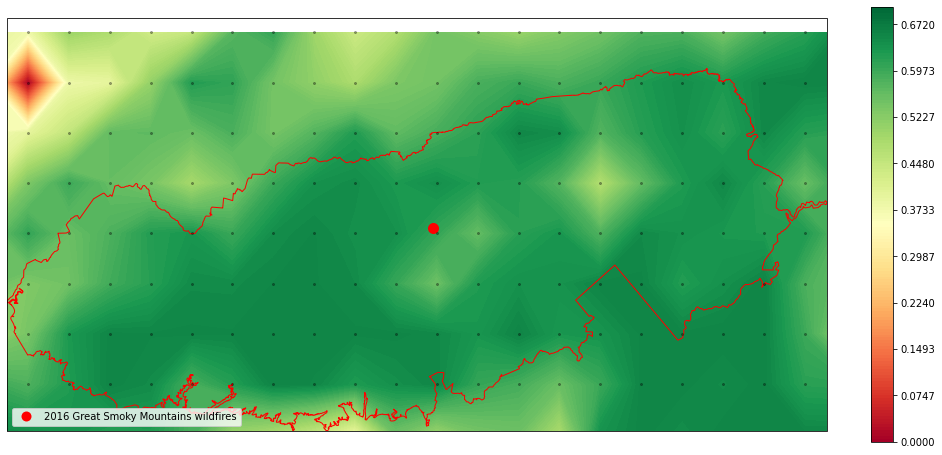

In [8]:
spatial_lon = spatial_data_2016_response.variables['lon'][:].squeeze()
spatial_lat = spatial_data_2016_response.variables['lat'][:].squeeze()
sif_spatial_data = spatial_data_2016_response.variables[vname][:].squeeze()
spatial_lon_2d, spatial_lat_2d = np.meshgrid(spatial_lon, spatial_lat)
fig_spatial_2016 = plt.figure(figsize=(16, 8))
ax_spatial_2016 = plt.axes(projection=ccrs.PlateCarree())
ax_spatial_2016.set_extent([gsmnp_bbox.maxx, gsmnp_bbox.minx, gsmnp_bbox.miny, gsmnp_bbox.maxy])
cf_spatial_2016 = ax_spatial_2016.contourf(spatial_lon_2d, spatial_lat_2d, sif_spatial_data, 200, levels=sif_levels, transform=ccrs.PlateCarree(), zorder=0, cmap='RdYlGn')
plt.colorbar(cf_spatial_2016, ax=ax_spatial_2016, fraction=0.032)
ax_spatial_2016.plot(spatial_lon_2d.flatten(), spatial_lat_2d.flatten(), marker='o', color='black', markersize=2,
        alpha=0.3, transform=ccrs.Geodetic(), zorder=2, linestyle='none')
gsmnp_bnd_4326.plot(ax=ax_spatial_2016, alpha=1, facecolor="none", edgecolor='red')
gsmnp_bnd_geo_df_4326.plot(column='place_name', ax=ax_spatial_2016, cmap=ListedColormap('red'), markersize=100, legend=True)

#### 4.4. Examine and visualize the returned data for 2017 summer

<GeoAxesSubplot:>

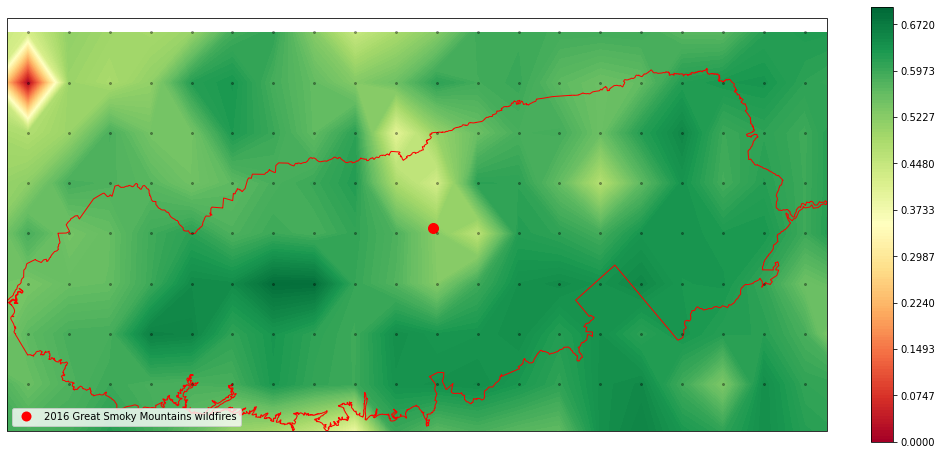

In [9]:
spatial_lon = spatial_data_2017_response.variables['lon'][:].squeeze()
spatial_lat = spatial_data_2017_response.variables['lat'][:].squeeze()
sif_spatial_data = spatial_data_2017_response.variables[vname][:].squeeze()
spatial_lon_2d, spatial_lat_2d = np.meshgrid(spatial_lon, spatial_lat)
fig_spatial_2017 = plt.figure(figsize=(16, 8))
ax_spatial_2017 = plt.axes(projection=ccrs.PlateCarree())
ax_spatial_2017.set_extent([gsmnp_bbox.maxx, gsmnp_bbox.minx, gsmnp_bbox.miny, gsmnp_bbox.maxy])
cf_spatial_2017 = ax_spatial_2017.contourf(spatial_lon_2d, spatial_lat_2d, sif_spatial_data, 200, levels=sif_levels, transform=ccrs.PlateCarree(), zorder=0, cmap='RdYlGn')
plt.colorbar(cf_spatial_2017, ax=ax_spatial_2017, fraction=0.032)
ax_spatial_2017.plot(spatial_lon_2d.flatten(), spatial_lat_2d.flatten(), marker='o', color='black', markersize=2,
        alpha=0.3, transform=ccrs.Geodetic(), zorder=2, linestyle='none')
gsmnp_bnd_4326.plot(ax=ax_spatial_2017, alpha=1, facecolor="none", edgecolor='red')
gsmnp_bnd_geo_df_4326.plot(column='place_name', ax=ax_spatial_2017, cmap=ListedColormap('red'), markersize=100, legend=True)

#### 4.5. The 2016 winter wildfires had a negative impact on SIF in the GSMNP area
Comapring the two maps above, SIF values in summer 2017 were generally lower than in summer 2016, especially in the area surrounding the fire center point.

### 5. Temporally subset the SIF data at the wildfires center point during the time period of 2015 - 2019

#### 5.1. Build a NCSS temporal subset request to retrieve a time series data for the wildfires center point

In [10]:
temporal_query = ncss.query()
# tell the query to subset at the fire center point
temporal_query.lonlat_point(fire_center_lon, fire_center_lat)
# tell the query to subset during the period 2015-01-1 to 2019-12-31
temporal_query.time_range(datetime.datetime(2015,1,1,0,0), datetime.datetime(2019,12,31,0,0))
temporal_query.variables(vname).accept('netcdf')
temporal_data_response = ncss.get_data(temporal_query)
temporal_data_response

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file file:/data/ornldaac/measures/17-MEASURES-0032/Global_SIF_OCO2_MODIS/Global_SIF_OCO2_MODIS.ncml
    time_coverage_start: 2015-01-08T18:00:00Z
    time_coverage_end: 2019-12-24T06:00:00Z
    geospatial_lat_min: 35.6295
    geospatial_lat_max: 35.630500000000005
    geospatial_lon_min: -83.4805
    geospatial_lon_max: -83.4795
    featureType: timeSeries
    dimensions(sizes): obs(116), station(1), station_id_strlen(9), station_description_strlen(34)
    variables(dimensions): float64 latitude(station), float64 longitude(station), |S1 station_id(station, station_id_strlen), |S1 station_description(station, station_description_strlen), float64 time(obs), int32 stationIndex(obs), float64 sif_ann(obs)
    groups: 

#### 5.2. Prepare data and time values suitable for plotting purpose

In [11]:
sif_temporal_data = temporal_data_response.variables[vname]
#print(sif_temporal_data[:].squeeze())
#print(time.units)
# convert time values to human-readable format
time = temporal_data_response.variables['time']
time_vals = num2pydate(time[:].squeeze(), time.units)
#print(time_vals)

#### 5.3. Make a SIF time series plot

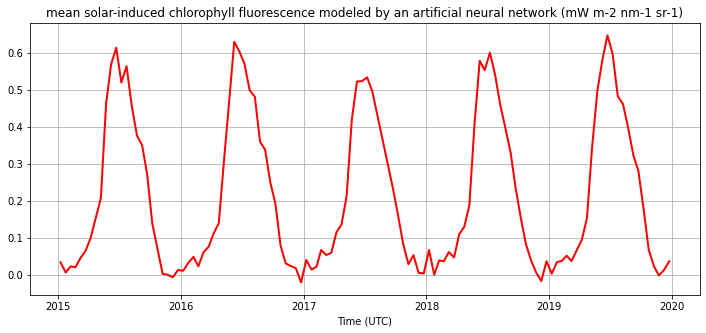

In [12]:
fig_temporal, ax_temporal = plt.subplots(1, 1, figsize=(12, 5))
ax_temporal.plot(time_vals, sif_temporal_data[:].squeeze(), 'r', linewidth=2)
ax_temporal.set_title('{} ({})'.format(sif_temporal_data.long_name, sif_temporal_data.units))
ax_temporal.set_xlabel('Time (UTC)')
ax_temporal.grid(True)

#### 5.4. The 2016 wildfires had a negative impact on SIF at the fire center point
In the time series plot, we see at the fire center point (~5km grid cell area) the annual peak values were typically above 0.6 prior to 2016. But in summer 2017, the year after the 2016 wildfires, the peak value decreased to ~0.52. But we also see an increasing trend SIF peak values from 2017 to 2019, which means vegetation was recovering.